## A COVID-19 Outcome Classification

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore') # To ignore warning messages

# I. Preprocessing
### Load the data

In [2]:
# Loading our dataset
df = pd.read_csv("Covid Data.csv")

# Print the shape (number of rows and columns) of the dataset
print(df.shape)

# Remove leading and trailing spaces from column names using lambda function and rename columns
df = df.rename(columns=lambda x: x.strip())

# print out and display dataframe as tables in HTML
display(HTML(df.head(10).to_html()))

(1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,2,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,2,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,2,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,2,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,2,2,2,2,2,2,2,2,2,3,2


### Check the data types and missing values.

In [3]:
# Check for data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

USMER                    int64
MEDICAL_UNIT             int64
SEX                      int64
PATIENT_TYPE             int64
DATE_DIED               object
INTUBED                  int64
PNEUMONIA                int64
AGE                      int64
PREGNANT                 int64
DIABETES                 int64
COPD                     int64
ASTHMA                   int64
INMSUPR                  int64
HIPERTENSION             int64
OTHER_DISEASE            int64
CARDIOVASCULAR           int64
OBESITY                  int64
RENAL_CHRONIC            int64
TOBACCO                  int64
CLASIFFICATION_FINAL     int64
ICU                      int64
dtype: object
USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                

### There are 0 missing values, because 97, 98, and 99 represent missing value in our dataset.
### Convert date died to binary feature.

In [4]:
# If 'DATE_DIED' is '9999-99-99', set 'DIED' to 0 (indicating not died), otherwise set it to 1 (indicating died)
df['DIED'] = [0 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df.drop('DATE_DIED', axis=1, inplace=True)

# Check for data types
print(df.dtypes)

display(HTML(df.head(10).to_html()))

USMER                   int64
MEDICAL_UNIT            int64
SEX                     int64
PATIENT_TYPE            int64
INTUBED                 int64
PNEUMONIA               int64
AGE                     int64
PREGNANT                int64
DIABETES                int64
COPD                    int64
ASTHMA                  int64
INMSUPR                 int64
HIPERTENSION            int64
OTHER_DISEASE           int64
CARDIOVASCULAR          int64
OBESITY                 int64
RENAL_CHRONIC           int64
TOBACCO                 int64
CLASIFFICATION_FINAL    int64
ICU                     int64
DIED                    int64
dtype: object


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED
0,2,1,1,1,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97,1
1,2,1,2,1,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97,1
2,2,1,2,2,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2,1
3,2,1,1,1,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97,1
4,2,1,2,1,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97,1
5,2,1,1,2,2,1,40,2,2,2,2,2,2,2,2,2,2,2,3,2,0
6,2,1,1,1,97,2,64,2,2,2,2,2,2,2,2,2,2,2,3,97,0
7,2,1,1,1,97,1,64,2,1,2,2,1,1,2,2,2,1,2,3,97,0
8,2,1,1,2,2,2,37,2,1,2,2,2,1,2,2,1,2,2,3,2,0
9,2,1,1,2,2,2,25,2,2,2,2,2,2,2,2,2,2,2,3,2,0


### Check how many missing values in each feature.

In [5]:
# Check how many missing values each feature have
df_null = df.copy()
for i in [97, 98, 99]:
   df_null.replace(i , np.nan, inplace = True)

print(df_null.isnull().sum())

df_null.head()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
DIED                         0
dtype: int64


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED
0,2,1,1,1,NaN,1.0,65.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN,1
1,2,1,2,1,NaN,1.0,72.0,NaN,2.0,2.0,...,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5,NaN,1
2,2,1,2,2,1.0,2.0,55.0,NaN,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
3,2,1,1,1,NaN,2.0,53.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN,1
4,2,1,2,1,NaN,2.0,68.0,NaN,1.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN,1


### 1 represents male, 2 represents female.

In [6]:
# Display the count of male and feamle values in the 'SEX' column
df.SEX.value_counts()

1    525064
2    523511
Name: SEX, dtype: int64

In [7]:
df.describe().round(3).T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
USMER,1.632,0.482,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,8.981,3.723,1.0,4.0,12.0,12.0,13.0
SEX,1.499,0.500,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1.191,0.393,1.0,1.0,1.0,1.0,2.0
INTUBED,79.523,36.869,1.0,97.0,97.0,97.0,99.0
PNEUMONIA,3.347,11.913,1.0,2.0,2.0,2.0,99.0
AGE,41.794,16.907,0.0,30.0,40.0,53.0,121.0
PREGNANT,49.766,47.511,1.0,2.0,97.0,97.0,98.0
DIABETES,2.186,5.424,1.0,2.0,2.0,2.0,98.0
COPD,2.261,5.132,1.0,2.0,2.0,2.0,98.0


### We can notice that we have major missing values at the following features:  
1- "INTUBED"  
2- "ICU"  
3- "PREGNANT"

In [8]:
# Display the shape
df.SEX.shape

(1048575,)

In [9]:
# Display the shape to see how many male and feamle values in the 'SEX' column
print(df[(df['SEX'] == 1)].shape)
print(df[(df['SEX'] == 2)].shape)

(525064, 21)
(523511, 21)


### Check for the pregnancy according to the gender.

In [10]:
# Feamle who is pregnant
df[(df['SEX'] == 1)]['PREGNANT']

0          2
3          2
5          2
6          2
7          2
          ..
1048563    2
1048564    2
1048565    2
1048567    2
1048569    2
Name: PREGNANT, Length: 525064, dtype: int64

In [11]:
# Display value counts when female who is pregnant
df[(df['SEX'] == 1)]['PREGNANT'].value_counts()

2     513179
1       8131
98      3754
Name: PREGNANT, dtype: int64

In [12]:
# Sum of the values
513179+8131+3754

525064

In [13]:
# Display value counts when male who is pregnant
df[(df['SEX'] == 2)]['PREGNANT']

1          97
2          97
4          97
11         97
12         97
           ..
1048570    97
1048571    97
1048572    97
1048573    97
1048574    97
Name: PREGNANT, Length: 523511, dtype: int64

In [14]:
# Display value counts when male
df[(df['SEX'] == 2)]['PREGNANT'].value_counts()

97    523511
Name: PREGNANT, dtype: int64

In [15]:
# Display value counts of 'PREGNANT' column when 'SEX' is equal to 2 and 'PREGNANT' is True
df[(df['SEX'] == 2) & (df['PREGNANT'])]['PREGNANT'].value_counts()

97    523511
Name: PREGNANT, dtype: int64

In [16]:
# Display value counts of 'PREGNANT'
df['PREGNANT'].value_counts()

97    523511
2     513179
1       8131
98      3754
Name: PREGNANT, dtype: int64

### As suspected, we noticed that all values of 98 are of the missing values corresponding to the female values, while all those of 97 are of the ones corresponding to the male values.
### So obviously we can replace all the corresponding values to the male section (97) with (2); since obviously men can't be pregnant.

In [17]:
# Replace all missing values to 2, since male cannot be pregnant
df['PREGNANT'].replace (97, 2, inplace = True)
df['PREGNANT'].value_counts()

2     1036690
1        8131
98       3754
Name: PREGNANT, dtype: int64

### Now, look at the ICU value counts to deal with missing values.

In [18]:
# Display value counts
df.ICU.value_counts()

97    848544
2     175685
1      16858
99      7488
Name: ICU, dtype: int64

In [19]:
# Iterate through combinations of 'PATIENT_TYPE' (1 and 2) and 'ICU' (1, 2, 97, 99)
for i in [1, 2, 97, 99]:
    for j in [1, 2]:
        print (f"At PATIENT_TYPE = {j} and at ICU = {i} the shape will be:", "\n")
        print (df[(df['PATIENT_TYPE'] == j) & (df['ICU'] == i)].shape, "\n",
               "--------------------------------------------------------------------------------", "\n\n")

At PATIENT_TYPE = 1 and at ICU = 1 the shape will be: 

(0, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 2 and at ICU = 1 the shape will be: 

(16858, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 1 and at ICU = 2 the shape will be: 

(0, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 2 and at ICU = 2 the shape will be: 

(175685, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 1 and at ICU = 97 the shape will be: 

(848544, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 2 and at ICU = 97 the shape will be: 

(0, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 1 and at ICU = 99 the shape will be: 

(0, 21) 
 -----------------

### From the above we can see that the missing values of (97) are all corresponding to the values of PATIENT_TYPE = 1 which is for non hospitalized patients, while those of (99) are the missing values of the hospitalized patients, which again can not be telled or predicted.  

### So we can replace all the values of (97) with (2); since obviously patients who have never been hospitalized couldn't possibly be admitted to the ICU.

In [20]:
# Replace occurrences of 'ICU' value 97 with 2 in the 'ICU' column
df['ICU'].replace (97, 2, inplace = True)
df.ICU.value_counts()

2     1024229
1       16858
99       7488
Name: ICU, dtype: int64

### Lastly, dealing with missing values in "INTUBED".

In [21]:
# Display value counts
df.INTUBED.value_counts()

97    848544
2     159050
1      33656
99      7325
Name: INTUBED, dtype: int64

In [22]:
# Iterate through combinations of 'PATIENT_TYPE' (1 and 2) and 'INTUBED' (1, 2, 97, 99)
for i in [1, 2, 97, 99]:
    for j in [1, 2]:
        print (f"At PATIENT_TYPE = {j} and at INTUBED = {i} the shape will be:", "\n")
        print (df[(df['PATIENT_TYPE'] == j) & (df['INTUBED'] == i)].shape, "\n",
               "--------------------------------------------------------------------------------", "\n\n")

At PATIENT_TYPE = 1 and at INTUBED = 1 the shape will be: 

(0, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 2 and at INTUBED = 1 the shape will be: 

(33656, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 1 and at INTUBED = 2 the shape will be: 

(0, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 2 and at INTUBED = 2 the shape will be: 

(159050, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 1 and at INTUBED = 97 the shape will be: 

(848544, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 2 and at INTUBED = 97 the shape will be: 

(0, 21) 
 -------------------------------------------------------------------------------- 


At PATIENT_TYPE = 1 and at INTUBED = 99 the shape will be: 


### Again and as predicted it's the same as the ICU case.
### So we can replace all the values of (97) with (2); since obviously patients who have never been hospitalized couldn't possibly be connected to the ventilator.

In [23]:
# Replace occurrences of 'INTUBED' value 97 with 2 in the 'INTUBED' column
df['INTUBED'].replace (97, 2, inplace = True)
df.INTUBED.value_counts()

2     1007594
1       33656
99       7325
Name: INTUBED, dtype: int64

### So, all the rest of these missing values (values of 98 & 99) can't be predicted as they will affect our analysis, which is based on true and actual real life values.
### In other words, we can't fill them by random using any filling (imputation) technique.

In [24]:
# Replace occurrences of values 98 and 99 with NA
for i in [98, 99]:
   df.replace(i , np.nan, inplace = True)

In [25]:
df.describe().round(3).T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
USMER,1.632,0.482,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,8.981,3.723,1.0,4.0,12.0,12.0,13.0
SEX,1.499,0.500,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1.191,0.393,1.0,1.0,1.0,1.0,2.0
INTUBED,1.968,0.177,1.0,2.0,2.0,2.0,2.0
PNEUMONIA,1.864,0.342,1.0,2.0,2.0,2.0,2.0
AGE,41.783,16.890,0.0,30.0,40.0,53.0,121.0
PREGNANT,1.992,0.088,1.0,2.0,2.0,2.0,2.0
DIABETES,1.880,0.324,1.0,2.0,2.0,2.0,2.0
COPD,1.986,0.119,1.0,2.0,2.0,2.0,2.0


### Removing rest of the missing values.

In [26]:
# Missing values

print(df.shape)
print(df.dropna().shape)

print(1048575 - 1019473)

print(29102 / 1048575)

(1048575, 21)
(1019473, 21)
29102
0.027753856424194742


In [27]:
# Drop the NA values
df.dropna(inplace = True)

# II. Data Analysis

In [28]:
print("People died:", dict(df['DIED'].value_counts())[1])
print("People alive:", dict(df['DIED'].value_counts())[0])

People died: 73258
People alive: 946215


Text(0, 0.5, 'Count')

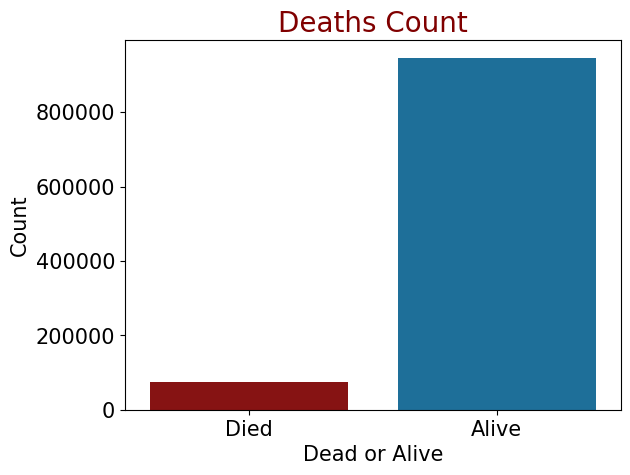

In [29]:
# Bar chart for deaths count
D = df['DIED']
D = D.replace(0, "Alive")
D = D.replace(1, "Died")
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Deaths Count', color = '#800000', fontsize = 20)
sns.countplot(x=D, palette = ['#990000',"#0a75ad"])
plt.xlabel("Dead or Alive", fontsize=15)
plt.ylabel("Count", fontsize=15)

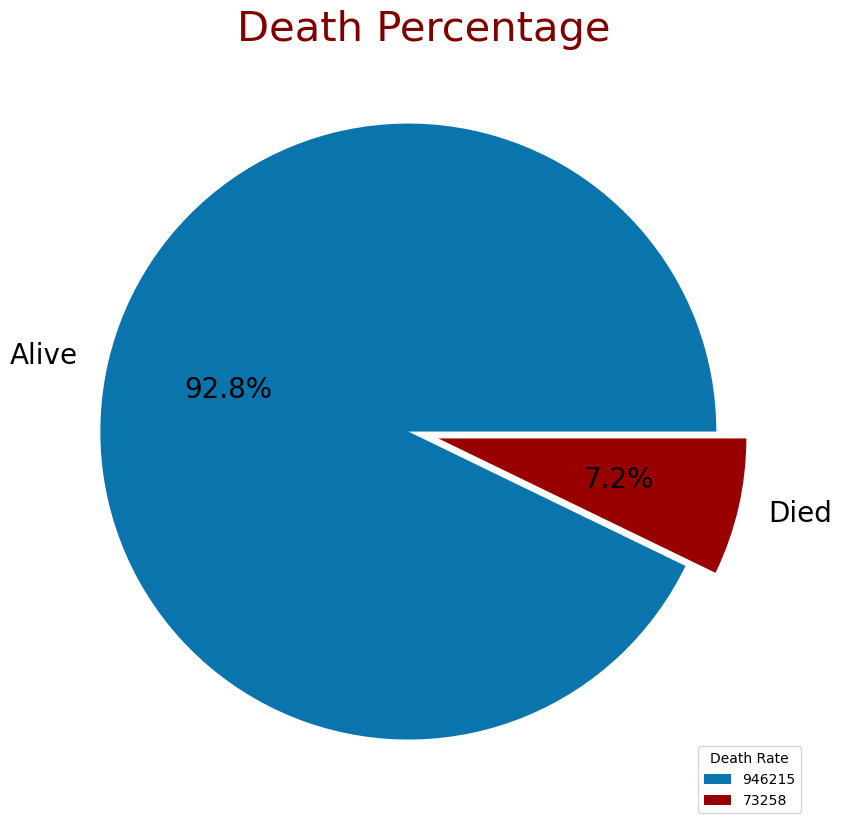

In [30]:
# Pie chart for deaths count
labels = ["Alive", "Died"]
sizes = df['DIED'].value_counts()
colors = ['#0a75ad', '#990000']
plt.figure(figsize = (10,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize':20, 'color':"black"}, colors = colors,
        explode=[0.05, 0.05])
plt.title('Death Percentage',color = '#800000',fontsize = 30)
plt.legend(df['DIED'].value_counts(), loc = 'lower right', title = 'Death Rate')
plt.show()

In [31]:
# Create new column tosee if the patient is in covid carrier or not
def Covid_or_Not(val):
    if val >= 4:
        return "Not a Covid 19 Carrier"
    else:
        return "A Covid 19 Carrier"

df_dead = df[df["DIED"] == 1]
    
df_dead['Covid_or_Not'] = df_dead["CLASIFFICATION_FINAL"].apply(Covid_or_Not)

print(df_dead["Covid_or_Not"].value_counts())

df_dead

A Covid 19 Carrier        52112
Not a Covid 19 Carrier    21146
Name: Covid_or_Not, dtype: int64


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED,Covid_or_Not
0,2,1,1,1,2.0,1.0,65.0,2.0,2.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier
1,2,1,2,1,2.0,1.0,72.0,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,5,2.0,1,Not a Covid 19 Carrier
2,2,1,2,2,1.0,2.0,55.0,2.0,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier
3,2,1,1,1,2.0,2.0,53.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,7,2.0,1,Not a Covid 19 Carrier
4,2,1,2,1,2.0,2.0,68.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047635,1,13,2,2,1.0,1.0,73.0,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier
1047636,1,13,2,1,2.0,1.0,82.0,2.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier
1047637,1,13,1,1,2.0,1.0,82.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier
1047638,1,13,2,2,1.0,1.0,80.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,2.0,3,2.0,1,A Covid 19 Carrier


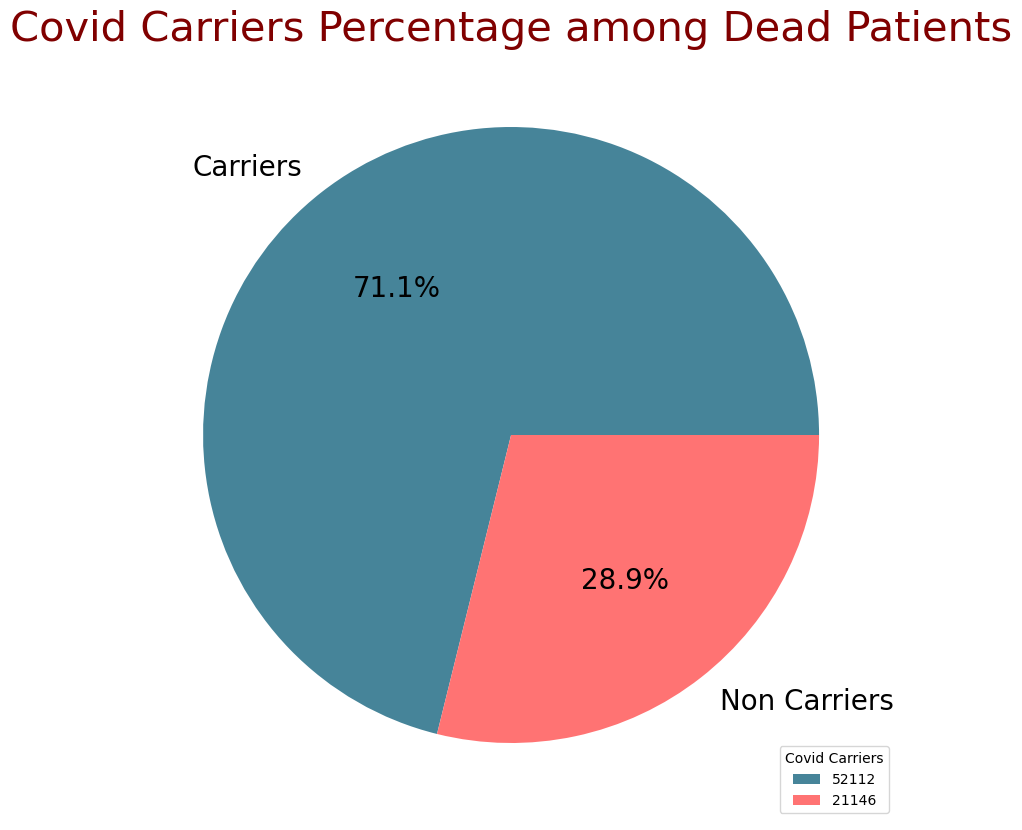

In [32]:
# Pie chart for covid carriers percentage among dead patients
labels = ["Carriers", "Non Carriers"]
sizes = df_dead['Covid_or_Not'].value_counts()
colors = ['#468499', '#ff7373']
plt.figure(figsize = (10,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize':20}, colors = colors)
plt.title('Covid Carriers Percentage among Dead Patients', color = 'Maroon', fontsize = 30)
plt.legend(df_dead['Covid_or_Not'].value_counts(), loc = 'lower right', title = 'Covid Carriers')
plt.show()

## Imbalance Issues

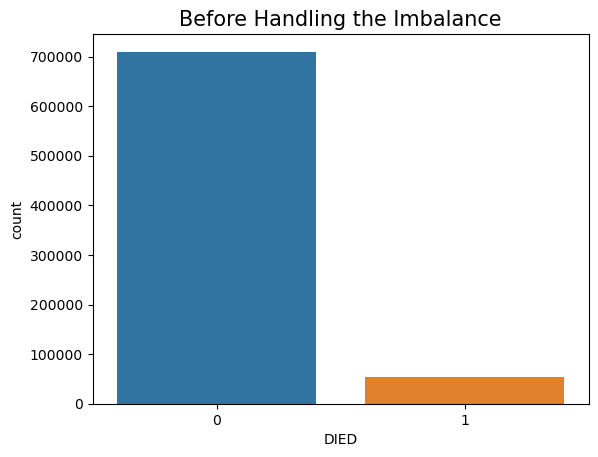

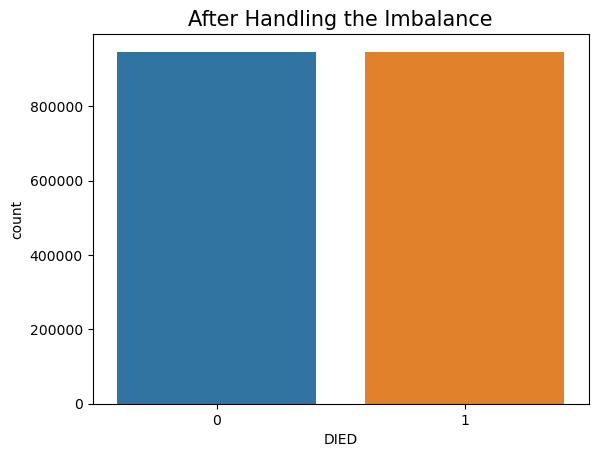

In [33]:
# Visualize imbalance issues and oversampling
x = df.drop('DIED' , axis= 1)
y = df['DIED']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

sns.countplot(x = y_train)
plt.title('Before Handling the Imbalance', color = 'black', fontsize = 15)
plt.show()

ros = RandomOverSampler(random_state=42)
ros.fit(x, y)
x_train, y_train = ros.fit_resample(x, y)

sns.countplot(x = y_train)
plt.title('After Handling the Imbalance', color = 'black', fontsize = 15)
plt.show()

# III. Feature Selection

In [34]:
# Oversampling

df_num=df.copy(deep=True)

# Split the dataset into features (x) and target variable (y)
x = df_num.drop('DIED' , axis= 1)
y = df_num['DIED']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Fit and apply oversampling to the training data
ros = RandomOverSampler(random_state=42)
ros.fit(x, y)
x_train, y_train = ros.fit_resample(x, y)

In [35]:
# Rename the column
df_num = df_num.rename(columns={'CLASIFFICATION_FINAL': 'CLASSIFICATION'})

print('Column Datatypes:\n',df_num.dtypes)

display(HTML(df_num.head(10).to_html()))

Column Datatypes:
 USMER               int64
MEDICAL_UNIT        int64
SEX                 int64
PATIENT_TYPE        int64
INTUBED           float64
PNEUMONIA         float64
AGE               float64
PREGNANT          float64
DIABETES          float64
COPD              float64
ASTHMA            float64
INMSUPR           float64
HIPERTENSION      float64
OTHER_DISEASE     float64
CARDIOVASCULAR    float64
OBESITY           float64
RENAL_CHRONIC     float64
TOBACCO           float64
CLASSIFICATION      int64
ICU               float64
DIED                int64
dtype: object


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASSIFICATION,ICU,DIED
0,2,1,1,1,2.0,1.0,65.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
1,2,1,2,1,2.0,1.0,72.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5,2.0,1
2,2,1,2,2,1.0,2.0,55.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
3,2,1,1,1,2.0,2.0,53.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,2.0,1
4,2,1,2,1,2.0,2.0,68.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
5,2,1,1,2,2.0,1.0,40.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0
6,2,1,1,1,2.0,2.0,64.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0
7,2,1,1,1,2.0,1.0,64.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3,2.0,0
8,2,1,1,2,2.0,2.0,37.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3,2.0,0
9,2,1,1,2,2.0,2.0,25.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,0


## Full Model

In [36]:
# All features result:

df_all = df_num.copy(deep=True)

# Create and fit a logistic regression model with the best parameters
clf = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=100, C=1.0, fit_intercept=True)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.8995601662030298
F1 = 0.8995601662030297
AUC = 0.9615766939671342


## Filter Model

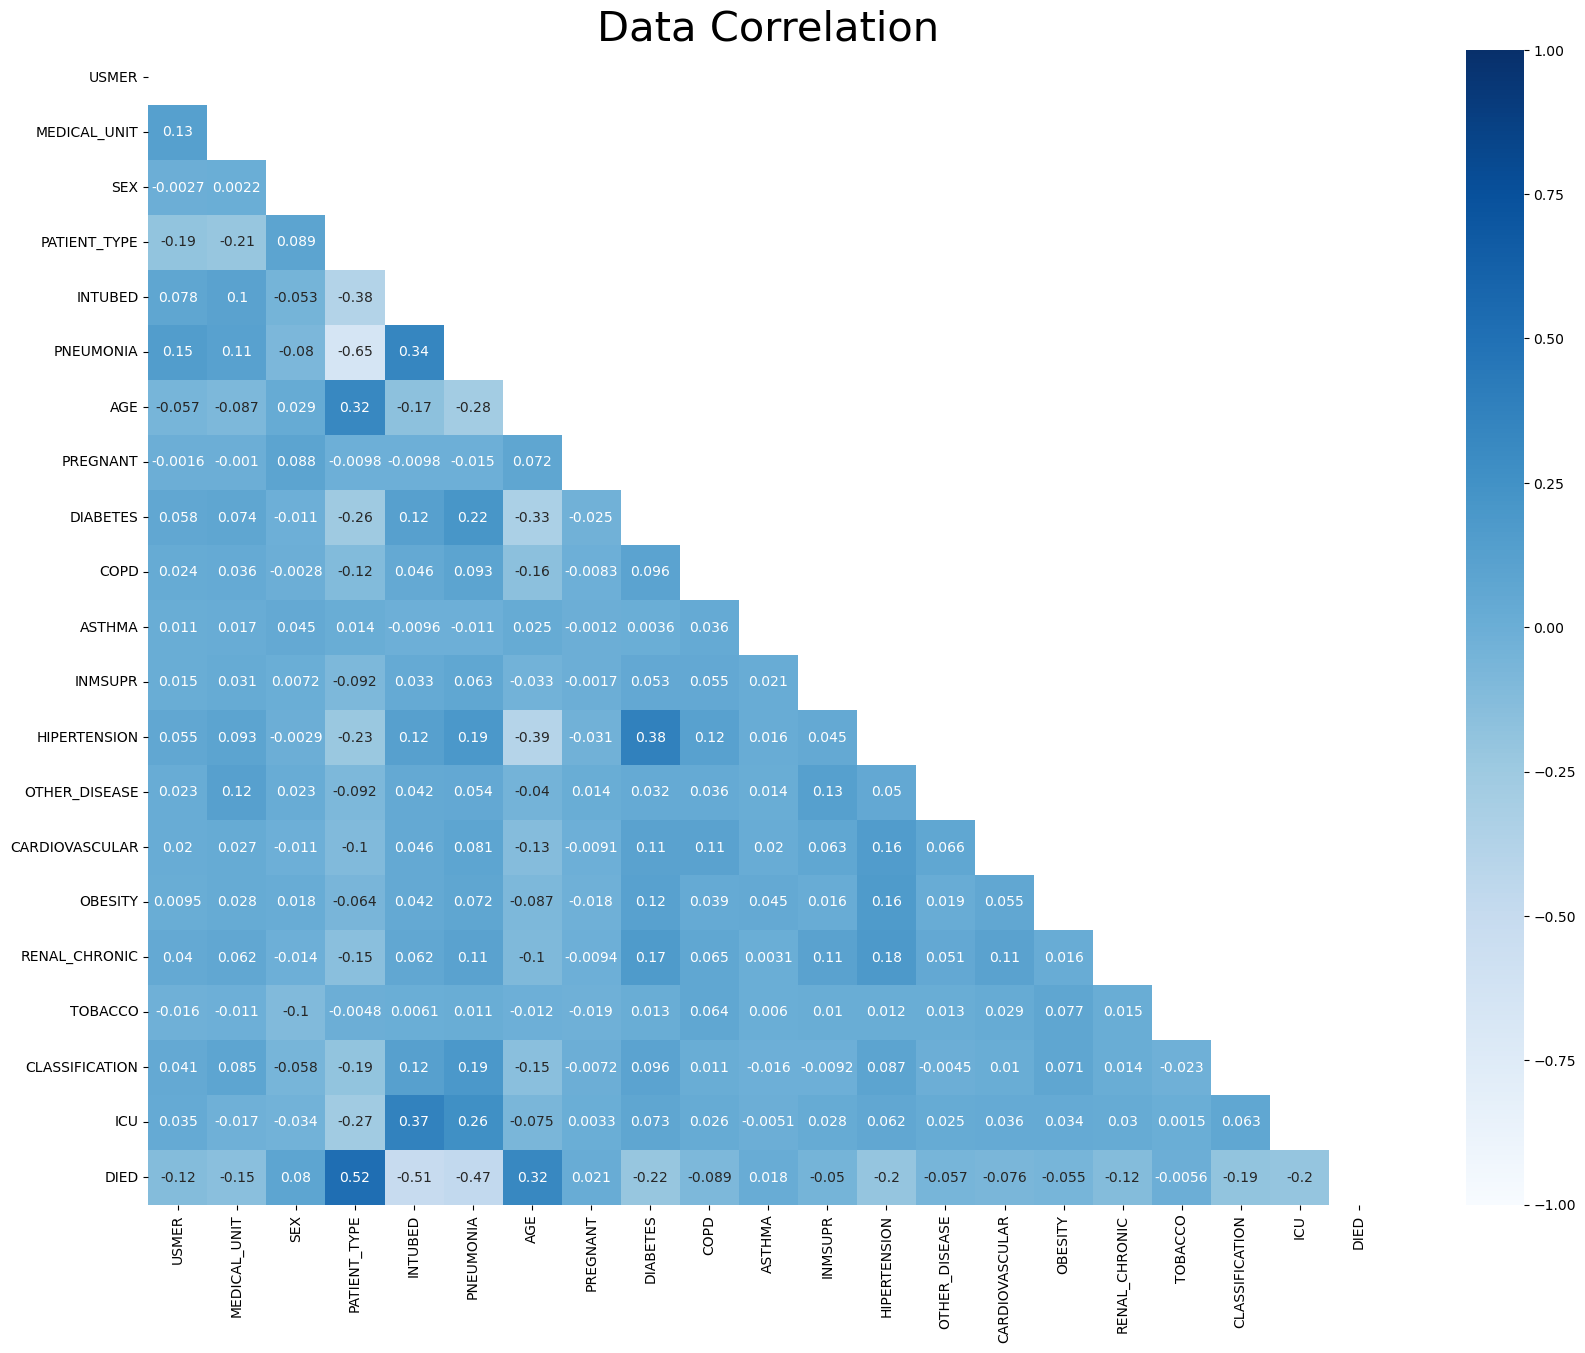

In [37]:
# Visualize the correlation matrix of numerical features in the DataFrame

fig, ax = plt.subplots(figsize=(20, 15))
mask=np.triu(np.ones_like(df_num.drop(columns=[]).corr()))
sns.heatmap(df_num.drop(columns=[]).corr(), mask = mask, annot = True, cmap = "Blues", vmin = -1, vmax = 1)
plt.title('Data Correlation', color = 'black', fontsize = 30)
plt.show()

In [38]:
# Compute the Pearson correlation and find features over the threshold

cor = df_num.corr()

cor_target = abs(cor["DIED"])
threshold = 0.3  # Adjust the threshold as needed
relevant_features = cor_target[cor_target > threshold]

print('\nSelected features by Pearson correlation:\n', relevant_features)


Selected features by Pearson correlation:
 PATIENT_TYPE    0.517780
INTUBED         0.505019
PNEUMONIA       0.471518
AGE             0.320668
DIED            1.000000
Name: DIED, dtype: float64


In [39]:
# cor features:

selected_columns = ['DIED', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'AGE']

# Create a new DataFrame with the selected features
df_num_cor = df_num.copy(deep=True)
df_num_cor = df_num[selected_columns]

# Split the dataset into features (x) and target variable (y)
x = df_num_cor.drop('DIED' , axis= 1)
y = df_num_cor['DIED']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Fit and apply oversampling to the training data
ros = RandomOverSampler(random_state=42)
ros.fit(x, y)
x_train, y_train = ros.fit_resample(x, y)

# Print out and display the updated dataframe as tables in HTML
display('df_num_feature:', HTML(df_num_cor.head(10).to_html()))

'df_num_feature:'

,DIED,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE
0,1,1,2.0,1.0,65.0
1,1,1,2.0,1.0,72.0
2,1,2,1.0,2.0,55.0
3,1,1,2.0,2.0,53.0
4,1,1,2.0,2.0,68.0
5,0,2,2.0,1.0,40.0
6,0,1,2.0,2.0,64.0
7,0,1,2.0,1.0,64.0
8,0,2,2.0,2.0,37.0
9,0,2,2.0,2.0,25.0


In [40]:
# Filter Model result

# Create and fit a logistic regression model with the best parameters
clf = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=100, C=1.0, fit_intercept=True)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.8971157732011347
F1 = 0.8971157732011347
AUC = 0.9570666265316232


## Wrapper Model

In [40]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector

# search method (forward)
feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           n_features_to_select='auto',
           direction='forward',
           scoring='accuracy',
           cv=5)

# Split the dataset into features (x) and target variable (y)
x = df_num.drop('DIED', axis=1)
y = df_num['DIED']

feature_selector.fit(x, y)
selected_features= feature_selector.get_support()
print(x.columns)
print(selected_features)

# Print the selected feautres after forward method
selected_columns = x.columns[selected_features]
print("\nThe selected features after forward method:\n", selected_columns)

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASSIFICATION', 'ICU'],
      dtype='object')
[False False  True False  True False False  True False  True  True  True
  True False  True False False  True  True False]

The selected features after forward method:
 Index(['SEX', 'INTUBED', 'PREGNANT', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'CARDIOVASCULAR', 'TOBACCO', 'CLASSIFICATION'],
      dtype='object')


In [41]:
# Define the columns to keep after the feature selection
selected_columns = ['DIED', 'SEX', 'INTUBED', 'PREGNANT', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'CARDIOVASCULAR', 'TOBACCO', 'CLASSIFICATION']

# Create a new DataFrame with the selected features
df_num_feature = df_num.copy(deep=True)
df_num_feature = df_num_feature[selected_columns]

# Split the dataset into features (x) and target variable (y)
x = df_num_feature.drop('DIED' , axis= 1)
y = df_num_feature['DIED']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Fit and apply oversampling to the training data
ros = RandomOverSampler(random_state=42)
ros.fit(x, y)
x_train, y_train = ros.fit_resample(x, y)

# Print out and display the updated dataframe as tables in HTML
display('df_num_feature:', HTML(df_num_feature.head(10).to_html()))

'df_num_feature:'

,DIED,SEX,INTUBED,PREGNANT,COPD,ASTHMA,INMSUPR,HIPERTENSION,CARDIOVASCULAR,TOBACCO,CLASSIFICATION
0,1,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,3
1,1,2,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,5
2,1,2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3
3,1,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7
4,1,2,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,3
5,0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3
6,0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3
7,0,1,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3
8,0,1,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,3
9,0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3


In [42]:
# Wrapper Model result

# Create and fit a logistic regression model with the best parameters
clf = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=100, C=1.0, fit_intercept=True)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.7750412957244702
F1 = 0.7750412957244702
AUC = 0.8546000401666558


## Feature Reduction

In [43]:
# PCA

x = df_num.drop('DIED', axis=1)
y = df_num['DIED']

# feature extraction
pca = PCA(n_components=10)
fit = pca.fit(x)

# summarize components
# print("Explained Variance: %s") % fit.explained_variance_ratio_
print('\nExplained variance: ', fit.explained_variance_ratio_)

var_sums = []
var_sums.append(0)

for var in fit.explained_variance_ratio_:
    l = len(var_sums)
    v_sum = var_sums[l-1] + var
    var_sums.append(v_sum)

var_sums.remove(0)
print('\nAccmulated variance: ', var_sums)   

PCAs = pca.fit_transform(x)

# Select the top 3 principal components since they already cover 99% of the total variance 
PCAs_selected = PCAs[:,:3]
df_PCAs = pd.DataFrame(data=PCAs_selected, columns=['PC1','PC2', 'PC3'])
df_PCAs['DIED'] = y

df_PCAs.dropna(subset=['DIED'], inplace=True)

display(HTML(df_PCAs.head(10).to_html()))


Explained variance:  [9.37816698e-01 4.62602567e-02 1.16288807e-02 8.75816225e-04
 8.11174753e-04 6.01727922e-04 4.66682948e-04 3.65855501e-04
 2.42220702e-04 2.38080701e-04]

Accmulated variance:  [0.9378166983509083, 0.984076955074605, 0.9957058357860914, 0.9965816520113541, 0.9973928267647584, 0.9979945546867215, 0.9984612376351554, 0.9988270931364029, 0.9990693138381155, 0.9993073945392933]


,PC1,PC2,PC3,DIED
0,23.340229,7.587898,1.508657,1.0
1,30.305963,7.342721,-0.576596,1.0
2,13.347267,7.816825,1.704341,1.0
3,11.262500,7.635965,-2.313053,1.0
4,26.340404,7.518488,1.454203,1.0
5,-1.649106,8.140225,1.950631,0.0
6,22.326504,7.595312,1.492776,0.0
7,22.348144,7.616159,1.531795,0.0
8,-4.636657,8.208280,1.996675,0.0
9,-16.647843,8.454749,2.173718,0.0


In [44]:
# Define the feature and target variables using df_PCAs
x = df_PCAs.drop('DIED', axis=1)
y = df_PCAs['DIED']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Fit and apply oversampling to the training data
ros = RandomOverSampler(random_state=42)
ros.fit(x, y)
x_train, y_train = ros.fit_resample(x, y)

# Define the logistic regression model with the best parameters
clf = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=150, C=0.1, fit_intercept=True)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.7436216251130345
F1 = 0.7436216251130345
AUC = 0.8521987116107806


### As a result, we are going to use all features to build classification models. 

# IV. Classifition Models

### Oversampling

In [52]:
# We are going to use the same train/test sets for each classification models
# Split the dataset into features (x) and target variable (y)
x = df_num.drop('DIED', axis=1)
y = df_num['DIED']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Fit and apply oversampling to the training data
print('\nOriginal dataset shape {}'.format(Counter(y_train)))
ros = RandomOverSampler(random_state=42)
ros.fit(x, y)
x_train, y_train = ros.fit_resample(x, y)
print('After undersampling dataset shape {}'.format(Counter(y_train)))


Original dataset shape Counter({0: 709591, 1: 55013})
After undersampling dataset shape Counter({1: 946215, 0: 946215})


## 1. Logistic Rregression Model

### Find the best parameters 

In [83]:
# 01. Logistic Regression

# Define the parameter combinations to test
penalties = ['l1', 'l2']
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
max_iters = [100, 150, 200]
Cs = [0.1, 1.0, 10.0]
fit_intercepts = [True, False]

# Initialize variables to track the best F1 score and AUC
best_f1 = 0
best_auc = 0
best_params = {}

# Iterate through parameter combinations
for penalty in penalties:
    for solver in solvers:
        # Check if the combination is valid
        if (penalty == 'l1' and solver not in ['liblinear', 'saga']) or \
           (penalty == 'elasticnet' and solver != 'saga') or \
           (penalty == 'l2' and solver == 'lbfgs'):
            continue

        for max_iter in max_iters:
            # liblinear solver doesn't support elasticnet penalty
            if solver == 'liblinear' and penalty == 'l1':
                continue
            
            for C in Cs:
                for fit_intercept in fit_intercepts:
                    # Create and fit a logistic regression model
                    clf = LogisticRegression(
                        penalty=penalty,
                        solver=solver,
                        max_iter=max_iter,
                        C=C,
                        fit_intercept=fit_intercept,
                        random_state=42
                    )
                    clf = clf.fit(x_train, y_train)
                    y_pred = clf.predict(x_test)
                    f1 = f1_score(y_test, y_pred, average='micro')

                    # Use LabelBinarizer to handle multiclass classification for AUC
                    lb = LabelBinarizer()
                    y_test_bin = lb.fit_transform(y_test)
                    y_pred_proba = clf.predict_proba(x_test)[:, 1]  # Extracting the relevant column
                    auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')
                    
                    # Update best F1 score, AUC, and parameters if a better model is found
                    if f1 > best_f1 and auc > best_auc:
                        best_f1 = f1
                        best_auc = auc
                        best_params = {
                            'penalty': penalty,
                            'solver': solver,
                            'max_iter': max_iter,
                            'C': C,
                            'fit_intercept': fit_intercept
                        }

# Print the best parameters and corresponding F1 score and AUC
print("Best Parameters:")
print(best_params)

Best Parameters:
{'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 100, 'C': 0.1, 'fit_intercept': True}


### Evaluation

In [55]:
# 01. Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Create and fit a logistic regression model with the best parameters
clf = LogisticRegression(penalty='l2', solver='liblinear', max_iter=100, C=0.1, fit_intercept=True, random_state=42)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.8994149935849397
F1 = 0.8994149935849397
AUC = 0.9617132112972513


## 2. Decision Tree

### Find the best parameters 

In [84]:
# 02. Decision Tree

# Define the parameter combinations to test
criterions = ['gini', 'entropy']
max_depths = [None, 10, 20]
min_samples_leafs = [1, 5, 10]

# Initialize variables to track the best F1 score and AUC
best_f1 = 0
best_auc = 0
best_params = {}

# Iterate through parameter combinations
for criterion in criterions:
    for max_depth in max_depths:
        for min_samples_leaf in min_samples_leafs:
            # Create and fit a Decision Tree model
            clf = DecisionTreeClassifier(
                criterion=criterion,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            f1 = f1_score(y_test, y_pred, average='micro')

            # Use LabelBinarizer to handle multiclass classification for AUC
            lb = LabelBinarizer()
            y_test_bin = lb.fit_transform(y_test)
            y_pred_proba = clf.predict_proba(x_test)[:, 1]  # Extracting the relevant column
            auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')

            # Update best F1 score, AUC, and parameters if a better model is found
            if f1 > best_f1 and auc > best_auc:
                best_f1 = f1
                best_auc = auc
                best_params = {
                    'criterion': criterion,
                    'max_depth': max_depth,
                    'min_samples_leaf': min_samples_leaf
                }

# Print the best parameters and corresponding F1 score and AUC
print("Best Parameters:")
print(best_params)

Best Parameters:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1}


### Evaluation

In [53]:
# 02. Decision Tree

# Create and fit a decision tree model with the best parameters
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, random_state=42)
clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.9481066744092063
F1 = 0.9481066744092063
AUC = 0.9929233205629101


## 3. SVM

### Find the best parameters 

In [45]:
# 03. SVM

# Define the parameter combinations to test
Cs = [0.1, 1.0, 10.0]
kernels = ['linear', 'rbf', 'poly']
gammas = ['scale', 'auto', 0.1]

# Initialize variables to track the best F1 score and AUC
best_f1 = 0
best_auc = 0
best_params = {}

# Iterate through parameter combinations
for C in Cs:
    for kernel in kernels:
        for gamma in gammas:
            # Create and fit an SVM model
            clf = SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                random_state=42
            )
            clf = clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            f1 = f1_score(y_test, y_pred, average='micro')

            # Use LabelBinarizer to handle multiclass classification for AUC
            lb = LabelBinarizer()
            y_test_bin = lb.fit_transform(y_test)
            y_pred_proba = clf.decision_function(x_test)  # decision_function for AUC in SVM
            auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')

            # Update best F1 score, AUC, and parameters if a better model is found
            if f1 > best_f1 and auc > best_auc:
                best_f1 = f1
                best_auc = auc
                best_params = {
                    'C': C,
                    'kernel': kernel,
                    'gamma': gamma
                }

# Print the best parameters and corresponding F1 score and AUC
print("Best Parameters:")
print(best_params)

Best Parameters:
{'C': 0.1, 'kernel': 'linear', 'gamma': 0.1}


### Evaluation

In [46]:
# 03. SVM

# Create and fit a Support Vector Machine (SVM) model with the best parameters
clf = SVC(C=0.1, kernel='linear', gamma=0.1, random_state=42)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.5005558984417934
F1 = 0.5005558984417934
AUC = 0.16319166135420335


## 4. Random Forest

### Find the best parameters 

In [48]:
# 04. Random Forest

# Define the parameter combinations to test
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 10, 20]
min_samples_split_values = [2, 5, 10]

# Initialize variables to track the best F1 score and AUC
best_f1 = 0
best_auc = 0
best_params = {}

# Iterate through parameter combinations
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            # Create and fit a Random Forest model
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            clf = clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            f1 = f1_score(y_test, y_pred, average='micro')

            # Use LabelBinarizer to handle multiclass classification for AUC
            lb = LabelBinarizer()
            y_test_bin = lb.fit_transform(y_test)
            y_pred_proba = clf.predict_proba(x_test)[:, 1]  # Extracting the relevant column
            auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')

            # Update best F1 score, AUC, and parameters if a better model is found
            if f1 > best_f1 and auc > best_auc:
                best_f1 = f1
                best_auc = auc
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                }

# Print the best parameters and corresponding F1 score and AUC
print("Best Parameters:")
print(best_params)

Best Parameters:
{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}


### Evaluation

In [50]:
# 04. Random Forest

# Create and fit a Random Forest model with the best parameters
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.9546847654235396
F1 = 0.9546847654235396
AUC = 0.9859147938002153


## 5. Bagging

### Find the best parameters 

In [47]:
# 05. Bagging
# Define the parameter combinations to test
n_estimators_values = [10, 50, 100]
max_samples_values = [1.0, 0.8, 0.6]
max_features_values = [1.0, 0.8, 0.6]

# Initialize variables to track the best F1 score and AUC
best_f1 = 0
best_auc = 0
best_params = {}

# Iterate through parameter combinations
for n_estimators in n_estimators_values:
    for max_samples in max_samples_values:
        for max_features in max_features_values:
            # Create and fit a BaggingClassifier model with a DecisionTree base estimator
            clf = BaggingClassifier(
                base_estimator=DecisionTreeClassifier(random_state=42),
                n_estimators=n_estimators,
                max_samples=max_samples,
                max_features=max_features,
                random_state=42
            )
            clf = clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            f1 = f1_score(y_test, y_pred, average='micro')

            # Use LabelBinarizer to handle multiclass classification for AUC
            lb = LabelBinarizer()
            y_test_bin = lb.fit_transform(y_test)
            y_pred_proba = clf.predict_proba(x_test)[:, 1]  # Extracting the relevant column
            auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')

            # Update best F1 score, AUC, and parameters if a better model is found
            if f1 > best_f1 and auc > best_auc:
                best_f1 = f1
                best_auc = auc
                best_params = {
                    'n_estimators': n_estimators,
                    'max_samples': max_samples,
                    'max_features': max_features
                }

# Print the best parameters and corresponding F1 score and AUC
print("Best Parameters:")
print(best_params)

Best Parameters:
{'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.6}


### Evaluation

In [49]:
# 05. Bagging

# Create and fit a bagging model with the best parameters
clf = BaggingClassifier(n_estimators=50, max_samples=1.0, max_features=0.6, random_state=42)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.9315927864250869
F1 = 0.9315927864250869
AUC = 0.9767590522449515


## 6. GradientBoostingClassifier

### Find the best parameters 

In [49]:
# 06. GradientBoostingClassifier

# Define the parameter combinations to test
learning_rate_values = [0.01, 0.1, 0.2]
n_estimators_values = [50, 100, 200]
max_depth_values = [3, 5, 7]

# Initialize variables to track the best F1 score and AUC
best_f1 = 0
best_auc = 0
best_params = {}

# Iterate through parameter combinations
for learning_rate in learning_rate_values:
    for n_estimators in n_estimators_values:
        for max_depth in max_depth_values:
            # Create and fit a GradientBoostingClassifier model
            clf = GradientBoostingClassifier(
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42
            )
            clf = clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            f1 = f1_score(y_test, y_pred, average='micro')

            # Use LabelBinarizer to handle multiclass classification for AUC
            lb = LabelBinarizer()
            y_test_bin = lb.fit_transform(y_test)
            y_pred_proba = clf.predict_proba(x_test)[:, 1]  # Extracting the relevant column
            auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro')

            # Update best F1 score, AUC, and parameters if a better model is found
            if f1 > best_f1 and auc > best_auc:
                best_f1 = f1
                best_auc = auc
                best_params = {
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth
                }

# Print the best parameters and corresponding F1 score and AUC
print("Best Parameters:")
print(best_params)

Best Parameters:
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5}


### Evaluation

In [50]:
# 06. GradientBoostingClassifier

# Create and fit a Gradient Boosting model with the best parameters
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
clf = clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)[:, 1]

# Calculate accuracy, F1 score, and AUC using hold-out evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
auc = roc_auc_score(y_test, y_pred_proba, average='micro')

print('By hold-out evaluation: ')
print("Accuracy =", acc)
print("F1 =", f1)
print("AUC =", auc)

By hold-out evaluation: 
Accuracy = 0.9183928405353534
F1 = 0.9183928405353534
AUC = 0.968408217187078


# V. Conclusion

## The best models are Decision Tree and Random Forest.

In [46]:
# Pick one of the best models
# Assuming x_train is a DataFrame with column names
feature_names = x_train.columns

# Fit the Random Forest model
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
clf = clf.fit(x_train, y_train)

# Get feature importances based on correlation with the target variable "DIED"
feature_importances = pd.Series(clf.feature_importances_, index=feature_names)

# Sort features based on importance
top5_features = feature_importances.abs().nlargest(5).index

# Print the top 5 features and their importance scores
print("Top 5 Features:")
i = 1
for feature in top5_features:
    print(f"{i}. {feature}")
    i += 1

Top 5 Features:
1. PATIENT_TYPE
2. AGE
3. PNEUMONIA
4. INTUBED
5. MEDICAL_UNIT
